In [27]:
import sys
(sys.path).insert(1,'/Users/pedroguicardi/Desktop/CMB_Analysis/MAPSIMS/directories')

import mapsims
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from ad_fns import *
from astropy.io import fits
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ccat_models import ccat_noise as CCAT_noise
import scipy.optimize as op

Used very simplistic model (don't even know if it is right) for testing and getting used to the algorithm:

$C^{XX}_\ell (\nu) = C^{XX}_{\ell,CMB} (\nu) + A^{XX}_s (\nu) \cdot (\frac{\ell}{\ell_0})^{\alpha_s}$

The goal is to then estimate $\alpha_s$ and $A^{XX}_s$.

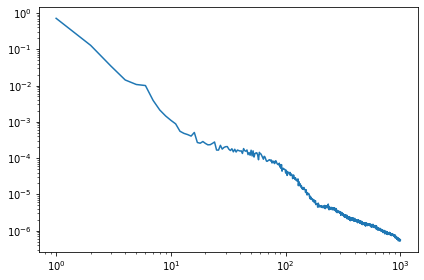

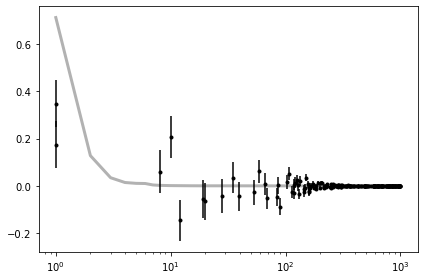

In [43]:
NSIDE = 256
cmb = mapsims.SOPrecomputedCMB(
    num=2,
    nside=NSIDE,
    lensed=False,
    aberrated=False,
    has_polarization=True,
    cmb_set=0,
    cmb_dir="mapsims/mapsims/tests/data",
    input_units="uK_CMB",
)
cls_cmb = hp.alm2cl(cmb.alm)
cmb_TT = cls_cmb[2]
ell = np.arange(len(cmb_TT))
ell = ell[1:1000]
cmb_TT = cmb_TT[1:1000]
#np.random.seed(123)

# Choose the "true" parameters.
A_s = 0.0000012
alpha_s = -3.0
ell0 = 84

y_true = cmb_TT + A_s * (ell/ell0)**(alpha_s) 
plt.plot(ell,y_true)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.clf()
# Generate some synthetic data from the model.
N = 200
B = 0.1
b = ell0 
ell_s = np.random.choice(ell,size=N)
yerr = B*np.exp(-ell_s/b)
y = np.random.normal(y_true[ell_s],yerr)

plt.errorbar(ell_s, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(ell, y_true, "k", alpha=0.3, lw=3)
plt.xscale('log')
plt.show()

Log Likelihood:

$l(\theta|y_1...y_n)= -\frac{1}{2} \sum_i \frac{(y_n - y(\ell_n))^2}{B^2 e^{-2\ell_n /b}} + ln(2\pi B^2 e^{-2\ell_n /b})$

In [77]:
def log_likelihood(theta, ell,ell_s, y_true, yerr):
    A_s_p ,alpha_s_p = theta
    model = cmb_TT + A_s_p * (ell/ell0)**(alpha_s_p) 
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y_true[ell_s] - model[ell_s]) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
A_s = 0.000018800
alpha_s = -2.230


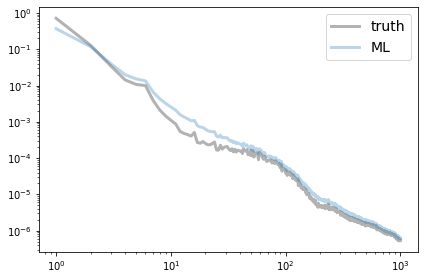

In [78]:
from scipy.optimize import minimize

#np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([A_s, alpha_s]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(ell,ell_s, y_true, yerr))
A_s_ml ,alpha_s_ml  = soln.x

print("Maximum likelihood estimates:")
print("A_s = {0:.9f}".format(A_s_ml))
print("alpha_s = {0:.3f}".format(alpha_s_ml))

y_ml = cmb_TT + A_s_ml * (ell/ell0)**(alpha_s_ml) 

#plt.errorbar(ell, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(ell, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(ell, y_ml, alpha=0.3, lw=3, label="ML")
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
# plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y");
plt.yscale("log")
plt.xscale("log")
plt.show()

In [79]:
def log_prior(theta):
    A_s_p ,alpha_s_p = theta
    if -5.0 < alpha_s_p < -0.5 and 0.0000012- 0.0000006 < A_s_p  < 0.0000012+ 0.0000006:
        return 0.0
    return -np.inf

In [80]:
def log_probability(theta, ell,ell_s, y_true, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ell,ell_s, y_true, yerr)

In [81]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(ell,ell_s, y_true, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:08<00:00, 584.70it/s]


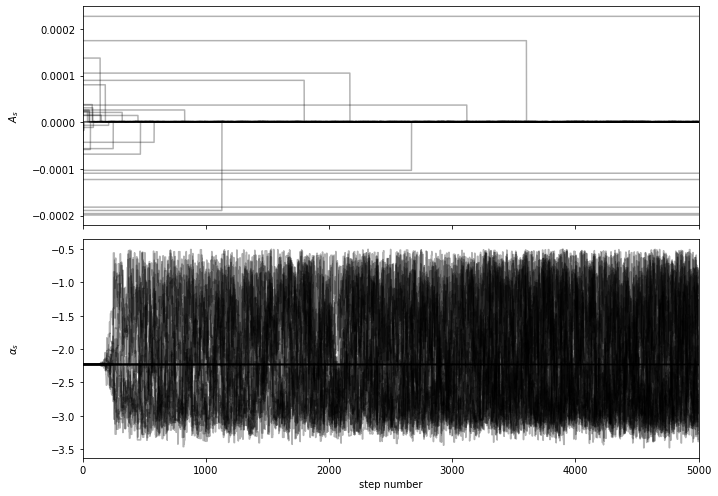

In [83]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$A_s$", r"$\alpha_s$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

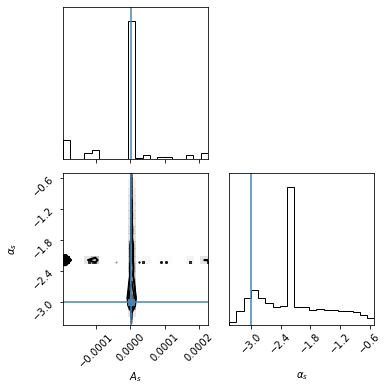

In [84]:
import corner


flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[A_s,alpha_s]
);






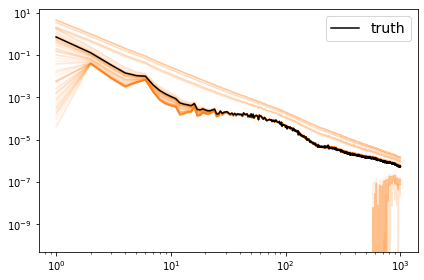

In [90]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(ell,cmb_TT + sample[0] * (ell/ell0)**(sample[1])  , "C1", alpha=0.1)
#plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(ell, y_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.show();

In [92]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.9f}_{{-{1:.9f}}}^{{{2:.9f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>